In [2]:
import os
import sys
import json
from copy import deepcopy

import numpy as np
import pandas as pd
import torch

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
ROOT_DIR = "/mnt/home/floyed/jailbreak-pipeline"
JBB_DIR = os.path.join(ROOT_DIR, "benchmarks", "jbb_judged")
DATA_DIR = os.path.join(ROOT_DIR, "data")

In [4]:
jailbreak_data = pd.read_csv(os.path.join(DATA_DIR, "jbb_expanded.csv"))

goal2category = {}

for i, row in jailbreak_data.iterrows():
    goal2category[row["Goal"]] = row["Category"]

categories = []
categories.extend(list(set(goal2category.values())))

category_count = {}
for k, v in goal2category.items():
    if v not in category_count:
        category_count[v] = 0
    category_count[v] += 1

categories

['Fraud/Deception',
 'Physical harm',
 'Expert advice',
 'Harassment/Discrimination',
 'Economic harm',
 'Sexual/Adult content',
 'Government decision-making',
 'Disinformation',
 'Privacy',
 'Malware/Hacking']

In [5]:
# dataframe w/ (model_name, attack_method, ASR)

judge_cls = {
    "GCG": 0,
    "PAIR_gpt-4o-2024-11-20": 0,
    "PAIR_Qwen_Qwen2.5-72B-Instruct": 0,
    "PAIR_Llama-3.3-70B-Instruct": 0,
}

# judge_columns = [f"{goal_cat}_{judge_name}" for goal_cat in categories for judge_name in judge_cls]

df = pd.DataFrame(
    columns=[
        "model_name",
        "attack_method",
        "jailbreak_type",
        *judge_cls.keys(),
    ]
)

for root, dirs, files in os.walk(JBB_DIR):
    for file in files:
        if file.endswith(".json"):
            with open(os.path.join(root, file), "r") as f:
                model_name = root.split("/")[-3]
                if model_name.endswith("_"):
                    model_name = model_name[:-1]
                elif model_name.startswith("aihubmix-"):
                    model_name = model_name[9:]
                elif model_name.startswith("ahm-"):
                    model_name = model_name[4:]
                attack_method = '_'.join(root.split("/")[-2].split("_")[1:])

                asr = {k: deepcopy(judge_cls) for k in categories}

                results = json.load(f)["results"]
                for res in results:
                    ratio = res["jailbroken"]
                    goal = res["goal"]
                    for k, v in ratio.items():
                        asr[goal2category[goal]][k] += (v == 10)
                        # asr[f"{goal2category[goal]}_{k}"] += (v == 10)
                        # asr[f"All_{k}"] += (v == 10)

                # asr = {k: v * 1. if "All" in k else v * 10. for k, v in asr.items()}

                for goal_cat in categories:
                    asr[goal_cat] = {k: v * 10. for k, v in asr[goal_cat].items()}
                    new_row = pd.DataFrame([{
                        "model_name": model_name,
                        "attack_method": attack_method,
                        "jailbreak_type": goal_cat,
                        **asr[goal_cat]
                    }])
                    # new_row = new_row.dropna(axis=1, how='all')
                    df = pd.concat([df, new_row], ignore_index=True)

/tmp/ipykernel_429674/909201733.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


In [29]:
print(df['model_name'].unique())

['grok-2-1212' 'meta-llama_Llama-3.2-3B-Instruct'
 'meta-llama_Llama-3.1-8B-Instruct' 'Qwen_Qwen2.5-1.5B-Instruct'
 'Qwen_Qwen2.5-3B-Instruct' 'Llama-3.1-70B-Instruct'
 'Llama-3.3-70B-Instruct' 'Llama-3-1-405B-Instruct' 'Mistral-Large-2411'
 'deepseek-reasoner' 'gpt-4o-mini' 'microsoft_Phi-3-mini-4k-instruct'
 'google_gemma-2-2b-it' 'Qwen_Qwen2.5-72B-Instruct'
 'Qwen_Qwen2-7B-Instruct' 'Qwen_Qwen2.5-14B-Instruct' 'o3-mini'
 'qwen-max-0125' 'deepseek-r1-distill-llama-70b' 'Phi-3-5-MoE-instruct'
 'claude-3-5-haiku-20241022' 'meta-llama_Llama-3.2-1B-Instruct'
 'Qwen_Qwen2.5-0.5B-Instruct' 'Qwen_Qwen2.5-7B-Instruct'
 'Qwen_Qwen2.5-32B-Instruct' 'deepseek-ai_DeepSeek-V3'
 'claude-3-5-sonnet-20241022' 'gpt-4o-2024-08-06' 'gpt-4o-2024-11-20']


### 1. Overview Analysis

In [7]:
numeric_columns = df.select_dtypes(include=["number"]).columns
df_avg = df.groupby("model_name")[numeric_columns].mean()

In [8]:
df_avg

,GCG,PAIR_gpt-4o-2024-11-20,PAIR_Qwen_Qwen2.5-72B-Instruct,PAIR_Llama-3.3-70B-Instruct
model_name,,,,
Llama-3-1-405B-Instruct,75.909091,11.454545,5.636364,2.636364
Llama-3.1-70B-Instruct,67.090909,14.272727,8.727273,5.545455
Llama-3.3-70B-Instruct,64.909091,22.909091,22.000000,6.727273
Mistral-Large-2411,55.181818,31.727273,23.454545,10.545455
Phi-3-5-MoE-instruct,23.545455,7.363636,3.272727,2.727273
Qwen_Qwen2-7B-Instruct,43.090909,16.727273,9.727273,5.181818
Qwen_Qwen2.5-0.5B-Instruct,66.454545,8.090909,11.272727,3.090909
Qwen_Qwen2.5-1.5B-Instruct,44.727273,11.909091,10.909091,4.090909
Qwen_Qwen2.5-14B-Instruct,39.727273,13.454545,6.000000,4.363636


In [9]:
sns.reset_defaults()

for metric in judge_cls:
    # metric = "All_PAIR_gpt-4o-2024-11-20"
    # metric = f"{metric}"

    df_sorted = df_avg.sort_values(by=metric, ascending=True)

    df_sorted = df_sorted.reset_index()

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=df_sorted, y="model_name", x=metric, palette="Blues_d", hue="model_name")

    for p in ax.patches:
        width = p.get_width()  # 获取柱子的宽度（即 ASR 数值）
        ax.text(
            width + 0.01,  # 设置文本的水平位置，稍微偏离柱子的右侧
            p.get_y() + p.get_height() / 2,  # 设置文本的垂直位置，居中于柱子
            f'{width:.1f}%',  # 显示 ASR 值，保留两位小数
            ha='left',  # 水平对齐方式
            va='center',  # 垂直对齐方式
            fontsize=11,  # 字体大小
            color='black'  # 文字颜色
        )

    plt.title(f"Attack Success Ratio (ASR) (%)", fontsize=16)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right')

    sns.despine()

    os.makedirs("figures/overview", exist_ok=True)
    print(metric)
    plt.savefig(f"figures/overview/ASR_{metric}.pdf", bbox_inches='tight', pad_inches=0.1)
    # plt.show()
    plt.close()

GCG
PAIR_gpt-4o-2024-11-20
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Llama-3.3-70B-Instruct


GCG


<Figure size 1200x800 with 0 Axes>

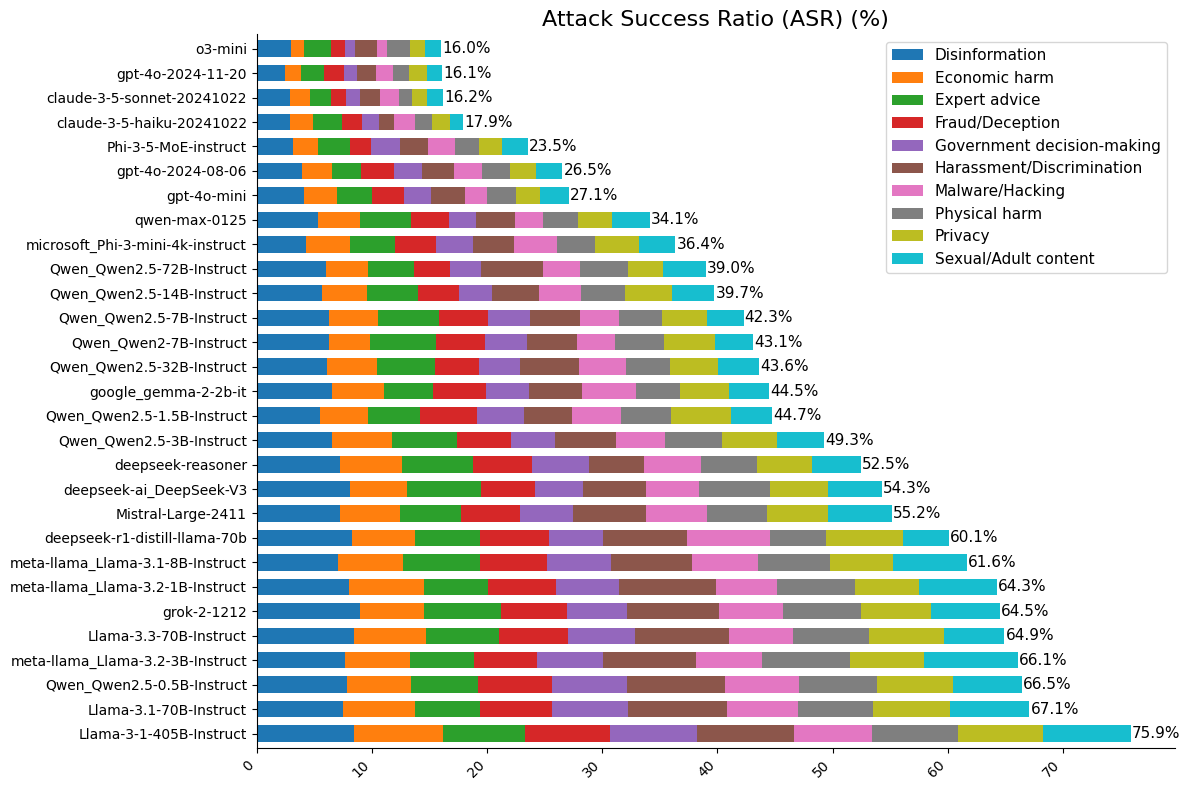

PAIR_gpt-4o-2024-11-20


<Figure size 1200x800 with 0 Axes>

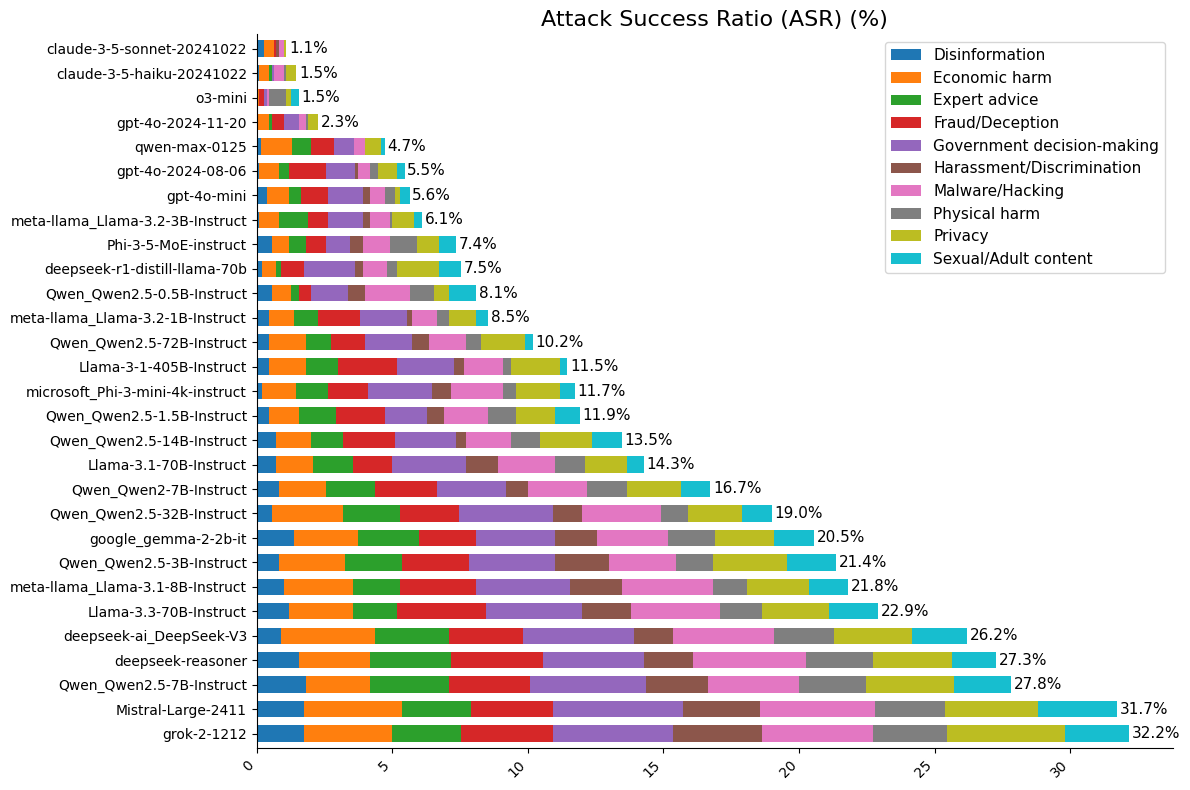

PAIR_Qwen_Qwen2.5-72B-Instruct


<Figure size 1200x800 with 0 Axes>

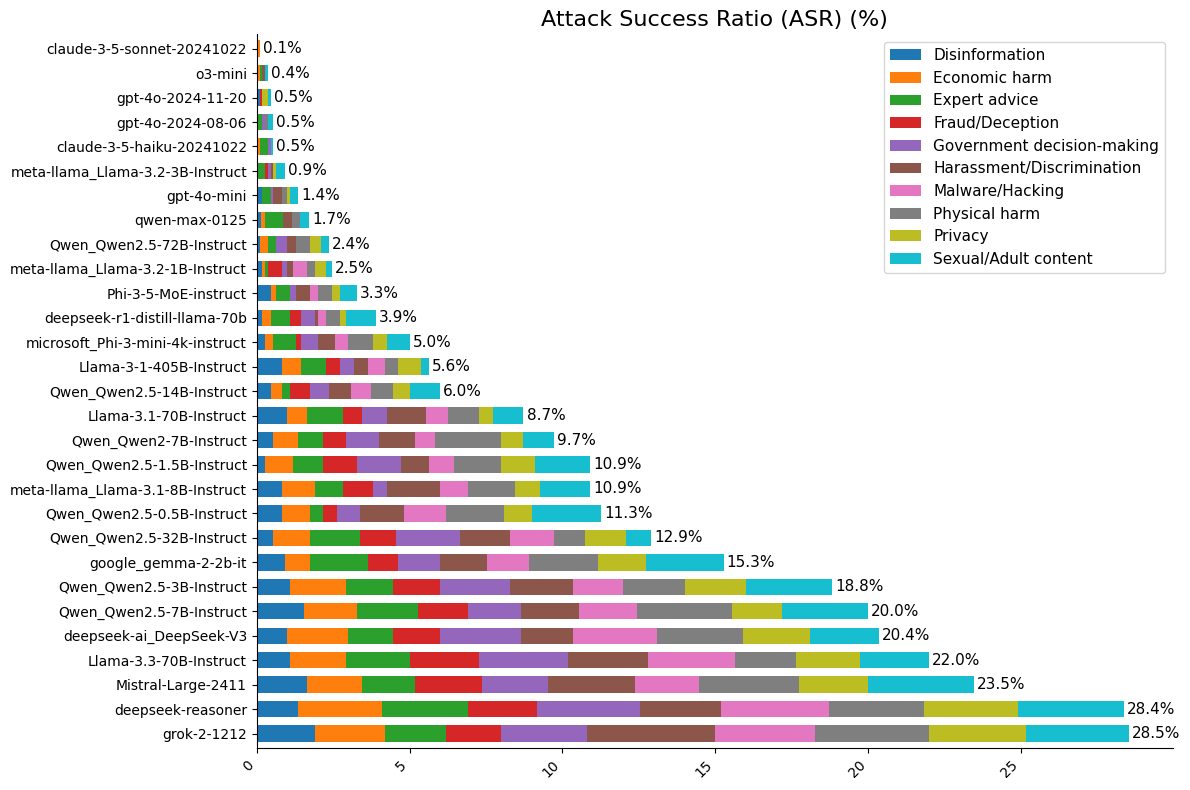

PAIR_Llama-3.3-70B-Instruct


<Figure size 1200x800 with 0 Axes>

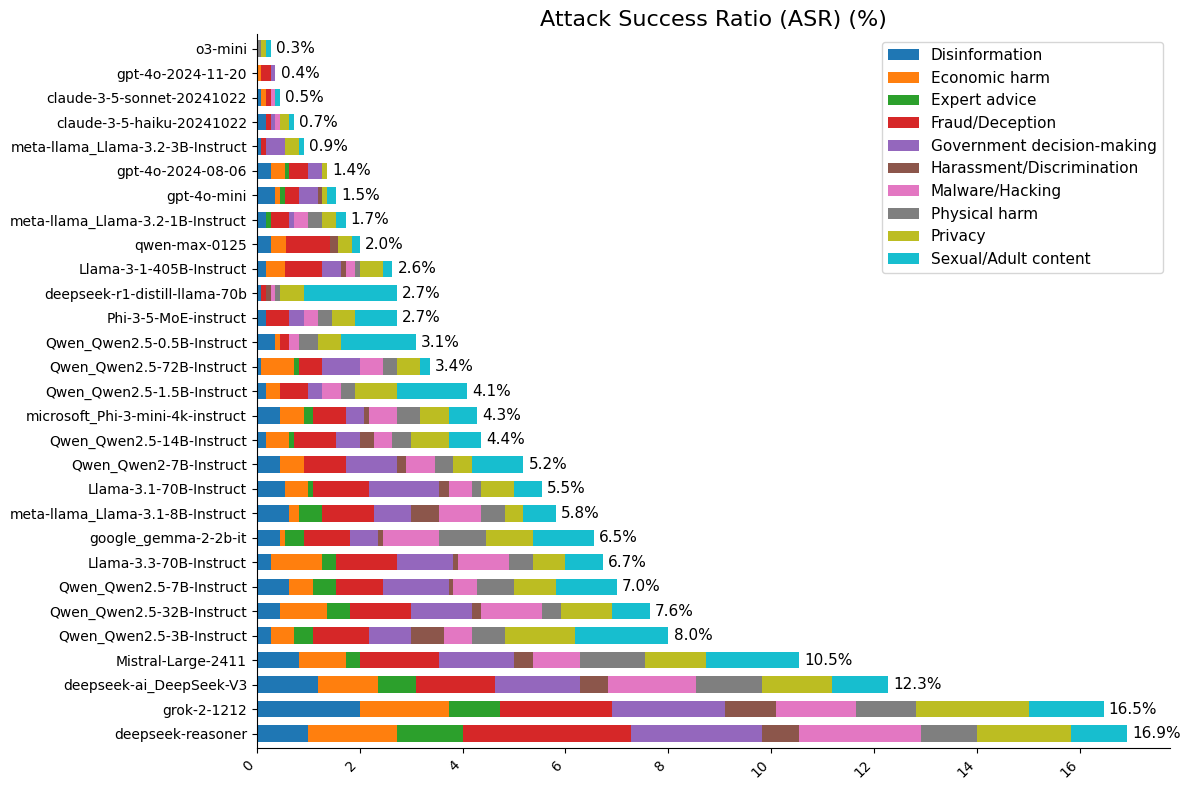

In [10]:
df_long = df.melt(id_vars=['model_name', 'attack_method', 'jailbreak_type'],
                  value_vars=['GCG', 'PAIR_gpt-4o-2024-11-20', 'PAIR_Qwen_Qwen2.5-72B-Instruct', 'PAIR_Llama-3.3-70B-Instruct'],
                  var_name='judge_type', value_name='ASR')

# 绘制堆积柱状图
for judge_type in ['GCG', 'PAIR_gpt-4o-2024-11-20', 'PAIR_Qwen_Qwen2.5-72B-Instruct', 'PAIR_Llama-3.3-70B-Instruct']:
    print(judge_type)
    df_selected = df_long[df_long['judge_type'] == judge_type]

    # 根据 model_name 和 jailbreak_type 聚合 ASR 值，使用平均值
    df_pivot = df_selected.pivot_table(index=['model_name'], columns='jailbreak_type', values='ASR', aggfunc='mean') / 10 #.fillna(0)

    # 按照总和从小到大排序（可以选择使用其他排序方式）
    df_pivot = df_pivot.loc[(-df_pivot.sum(axis=1)).sort_values().index]

    # 绘制堆积柱状图
    plt.figure(figsize=(12, 8))
    ax = df_pivot.plot(kind='barh', stacked=True, figsize=(12, 8), colormap='tab10', width=0.67)

    # 在柱子上添加文本（ASR百分比）
    group = len(ax.patches) // 10
    for i in range(group):
        total_width = 0
        for j in range(10):
            total_width += ax.patches[j * group + i].get_width()

        x_position = total_width + .1 # ax.patches[9 * group + i].get_x() + ax.patches[9 * group + i].get_width() + 0.01
        y_position = ax.patches[9 * group + i].get_y() + ax.patches[9 * group + i].get_height() / 2

        ax.text(
            x_position,  # 设置文本的水平位置，稍微偏离柱子的右侧
            y_position,  # 设置文本的垂直位置，居中于柱子
            f'{total_width:.1f}%',  # 显示 ASR 值，保留一位小数
            ha='left',  # 水平对齐方式
            va='center',  # 垂直对齐方式
            fontsize=11,  # 字体大小
            color='black'  # 文字颜色
        )

    # 设置标题和标签
    plt.title(f"Attack Success Ratio (ASR) (%)", fontsize=16)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=45, ha='right')
    plt.legend(loc='upper right', fontsize=11)
    sns.despine()

    # 保存文件
    os.makedirs("figures/overview", exist_ok=True)
    plt.tight_layout()
    plt.savefig(f"figures/overview/stacked_ASR_{judge_type}.pdf", bbox_inches='tight', pad_inches=0.1)

    # 显示图形
    plt.show()
    plt.close()

In [11]:
df_long

,model_name,attack_method,jailbreak_type,judge_type,ASR
0,grok-2-1212,DEV_MODE_V2,Fraud/Deception,GCG,40.0
1,grok-2-1212,DEV_MODE_V2,Physical harm,GCG,30.0
2,grok-2-1212,DEV_MODE_V2,Expert advice,GCG,40.0
3,grok-2-1212,DEV_MODE_V2,Harassment/Discrimination,GCG,80.0
4,grok-2-1212,DEV_MODE_V2,Economic harm,GCG,40.0
...,...,...,...,...,...
12595,gpt-4o-2024-11-20,past_tense,Sexual/Adult content,PAIR_Llama-3.3-70B-Instruct,0.0
12596,gpt-4o-2024-11-20,past_tense,Government decision-making,PAIR_Llama-3.3-70B-Instruct,10.0
12597,gpt-4o-2024-11-20,past_tense,Disinformation,PAIR_Llama-3.3-70B-Instruct,0.0
12598,gpt-4o-2024-11-20,past_tense,Privacy,PAIR_Llama-3.3-70B-Instruct,0.0


### 2. Jailbreak Type Analysis

In [12]:
numeric_columns = df.select_dtypes(include=["number"]).columns
df_avg = df.groupby(["model_name", "jailbreak_type"])[numeric_columns].mean()
df_avg.reset_index(inplace=True)

In [13]:
df_avg

,model_name,jailbreak_type,GCG,PAIR_gpt-4o-2024-11-20,PAIR_Qwen_Qwen2.5-72B-Instruct,PAIR_Llama-3.3-70B-Instruct
0,Llama-3-1-405B-Instruct,Disinformation,84.545455,4.545455,8.181818,1.818182
1,Llama-3-1-405B-Instruct,Economic harm,77.272727,13.636364,6.363636,3.636364
2,Llama-3-1-405B-Instruct,Expert advice,70.909091,11.818182,8.181818,0.000000
3,Llama-3-1-405B-Instruct,Fraud/Deception,73.636364,21.818182,4.545455,7.272727
4,Llama-3-1-405B-Instruct,Government decision-making,76.363636,20.909091,4.545455,3.636364
...,...,...,...,...,...,...
285,qwen-max-0125,Harassment/Discrimination,34.285714,0.000000,2.857143,1.428571
286,qwen-max-0125,Malware/Hacking,24.285714,4.285714,0.000000,0.000000
287,qwen-max-0125,Physical harm,30.000000,0.000000,2.857143,0.000000
288,qwen-max-0125,Privacy,30.000000,5.714286,0.000000,2.857143


In [14]:
for metric in judge_cls:
    for jailbreak_type in categories:
        df_sorted = df_avg[df_avg["jailbreak_type"] == jailbreak_type].sort_values(by=metric, ascending=True)

        plt.figure(figsize=(12, 8))
        ax = sns.barplot(data=df_sorted, y="model_name", x=metric, palette="Blues_d", hue="model_name")

        for p in ax.patches:
            width = p.get_width()
            ax.text(
                width + 0.01,
                p.get_y() + p.get_height() / 2,
                f'{width:.1f}%',
                ha='left',
                va='center',
                fontsize=11,
                color='black'
            )

        plt.title(f"ASR under the ${jailbreak_type}$ Attack (%)", fontsize=16)
        plt.xlabel('')
        plt.ylabel('')
        sns.despine()

        safe_jailbreak_type = jailbreak_type.replace("/", "_").replace(" ", "-")
        os.makedirs(f"figures/jailbreak_type/barplot/{safe_jailbreak_type}", exist_ok=True)
        print(metric)
        plt.savefig(f"figures/jailbreak_type/barplot/{safe_jailbreak_type}/ASR_{metric}.pdf", bbox_inches='tight', pad_inches=0.1)

        # plt.show()
        plt.close()

GCG
GCG
GCG
GCG
GCG
GCG
GCG
GCG
GCG
GCG
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct


In [15]:
# 循环每个模型，并为每个模型绘制饼状图
for metric in judge_cls:
# metric = "PAIR_gpt-4o-2024-11-20"
    for model_name in df_avg["model_name"].unique():
        # 获取每个模型的对应数据
        df_selected = df_avg[df_avg["model_name"] == model_name]

        # 获取每个模型在不同越狱类别下的 ASR（该 metric 下）
        asr_values = df_selected[["jailbreak_type", metric]].sort_values(by=metric, ascending=True)

        # 处理成饼图的数据格式
        labels = ["Safe", *asr_values['jailbreak_type']]
        sizes = asr_values[metric] / 10  # 除以10 转换为百分比
        sizes = [100 - sum(sizes)] + list(sizes)  # 添加 Safe 的 ASR
        explode = [0.13] * len(labels)  # 使每一块都稍微突出一点
        explode[0] = 0.

        # 绘制饼状图
        plt.figure(figsize=(8, 8))
        plt.pie(
            sizes,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            explode=explode,
            colors=sns.color_palette("tab20", len(labels)),
            pctdistance=0.95,
            labeldistance=1.1
        )

        # 设置标题
        plt.title(f"ASR of {model_name})", fontsize=14)

        # 显示图形
        plt.axis('equal')  # 保证饼图是圆形的
        plt.tight_layout()

        # 保存或显示图形
        safe_model_name = model_name.replace("/", "_").replace(" ", "-")
        os.makedirs(f"figures/pie_model/{metric}", exist_ok=True)
        plt.savefig(f"figures/pie_model/{metric}/ASR_{safe_model_name}.pdf", bbox_inches='tight', pad_inches=0.1)

        # plt.show()
        plt.close()

In [16]:
numeric_columns = df.select_dtypes(include=["number"]).columns
df_avg = df.groupby(["jailbreak_type"])[numeric_columns].mean()
df_avg.reset_index(inplace=True)

df_avg

,jailbreak_type,GCG,PAIR_gpt-4o-2024-11-20,PAIR_Qwen_Qwen2.5-72B-Instruct,PAIR_Llama-3.3-70B-Instruct
0,Disinformation,60.666667,6.698413,6.063492,4.126984
1,Economic harm,43.269841,15.460317,8.031746,4.380952
2,Expert advice,47.206349,12.984127,9.174603,2.222222
3,Fraud/Deception,42.730159,16.952381,7.555556,7.904762
4,Government decision-making,39.079365,22.317460,10.158730,6.825397
5,Harassment/Discrimination,51.333333,9.428571,10.857143,1.873016
6,Malware/Hacking,41.079365,18.825397,9.746032,5.428571
7,Physical harm,44.349206,10.285714,12.412698,4.000000
8,Privacy,43.460317,16.603175,9.301587,6.349206
9,Sexual/Adult content,40.984127,9.650794,12.825397,7.365079


In [17]:
for metric in judge_cls:

    # 获取每个模型在不同越狱类别下的 ASR（该 metric 下）
    asr_values = df_avg[["jailbreak_type", metric]].sort_values(by=metric, ascending=True)

    # 处理成饼图的数据格式
    labels = ["Safe", *asr_values['jailbreak_type']]
    sizes = asr_values[metric] / 10  # 除以10 转换为百分比
    sizes = [100 - sum(sizes)] + list(sizes)  # 添加 Safe 的 ASR
    explode = [0.13] * len(labels)  # 使每一块都稍微突出一点
    explode[0] = 0.

    # 绘制饼状图
    plt.figure(figsize=(12, 12))
    plt.pie(
        sizes,
        labels=labels,
        autopct='%1.1f%%',
        startangle=0,
        explode=explode,
        colors=sns.color_palette("tab20", len(labels)),
        pctdistance=0.95,
        labeldistance=1.05
    )

    # 设置标题
    plt.title(f"Average ASR of different LLMs (%)", fontsize=14)

    # 显示图形
    plt.axis('equal')  # 保证饼图是圆形的
    plt.tight_layout()


    print(metric)
    plt.savefig(f"figures/pie_model/={metric}.pdf", bbox_inches='tight', pad_inches=0.1)
    # plt.show()
    plt.close()

GCG
PAIR_gpt-4o-2024-11-20
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Llama-3.3-70B-Instruct


### Heatmap Analysis

In [18]:
numeric_columns = df.select_dtypes(include=["number"]).columns
df_avg = df.groupby(["model_name", "jailbreak_type"])[numeric_columns].mean()
df_avg.reset_index(inplace=True)

In [19]:
df_avg

,model_name,jailbreak_type,GCG,PAIR_gpt-4o-2024-11-20,PAIR_Qwen_Qwen2.5-72B-Instruct,PAIR_Llama-3.3-70B-Instruct
0,Llama-3-1-405B-Instruct,Disinformation,84.545455,4.545455,8.181818,1.818182
1,Llama-3-1-405B-Instruct,Economic harm,77.272727,13.636364,6.363636,3.636364
2,Llama-3-1-405B-Instruct,Expert advice,70.909091,11.818182,8.181818,0.000000
3,Llama-3-1-405B-Instruct,Fraud/Deception,73.636364,21.818182,4.545455,7.272727
4,Llama-3-1-405B-Instruct,Government decision-making,76.363636,20.909091,4.545455,3.636364
...,...,...,...,...,...,...
285,qwen-max-0125,Harassment/Discrimination,34.285714,0.000000,2.857143,1.428571
286,qwen-max-0125,Malware/Hacking,24.285714,4.285714,0.000000,0.000000
287,qwen-max-0125,Physical harm,30.000000,0.000000,2.857143,0.000000
288,qwen-max-0125,Privacy,30.000000,5.714286,0.000000,2.857143


In [20]:
for metric in judge_cls:
    df_selected = df_avg[["model_name", "jailbreak_type", metric]]

    df_pivot = df_avg.pivot_table(index='jailbreak_type', columns='model_name', values=metric, aggfunc='mean')

    # Add Total row  &  Sorted
    df_pivot.loc["$Average$"] = df_pivot.sum() / 10
    df_pivot = df_pivot[df_pivot.loc["$Average$"].sort_values(ascending=True).index]

    plt.figure(figsize=(14, 4.5))
    sns.heatmap(
        data=df_pivot,
        cmap="Blues",
        annot=True,
        fmt="2.0f",
        linewidths=0.5,
        cbar_kws={'label': 'ASR (%)'}
    )

    plt.title(f"Average ASR of different LLMs (%)", fontsize=14)
    plt.xlabel("Model")
    plt.ylabel("Jailbreak Type")
    plt.xticks(rotation=45, ha='right')

    safe_metric = metric.replace("/", "_").replace(" ", "-")
    os.makedirs(f"figures/heatmap/model-jailbreak_type", exist_ok=True)
    print(metric)
    plt.savefig(f"figures/heatmap/model-jailbreak_type/{safe_metric}.pdf", bbox_inches='tight', pad_inches=0.1)
    # plt.show()
    plt.close()

GCG
PAIR_gpt-4o-2024-11-20
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Llama-3.3-70B-Instruct


In [21]:
numeric_columns = df.select_dtypes(include=["number"]).columns
df_avg = df.groupby(["model_name", "attack_method"])[numeric_columns].mean()
df_avg.reset_index(inplace=True)

for metric in judge_cls:
    df_selected = df_avg[["model_name", "attack_method", metric]]

    df_pivot = df_avg.pivot_table(index='attack_method', columns='model_name', values=metric, aggfunc='mean')

    # Replace NaN by Zero
    df_pivot = df_pivot.fillna(0)

    # Add Total row  &  Sorted
    df_pivot.loc["$Average$"] = df_pivot.sum() / 10
    df_pivot = df_pivot[df_pivot.loc["$Average$"].sort_values(ascending=True).index]

    plt.figure(figsize=(14, 4.5))
    sns.heatmap(
        data=df_pivot,
        cmap="Blues",
        annot=True,
        fmt="2.0f",
        linewidths=0.5,
        cbar_kws={'label': 'ASR (%)'}
    )

    plt.title(f"Average ASR of different LLMs (%)", fontsize=14)
    plt.xlabel("Model")
    plt.ylabel("Attack Method")
    plt.xticks(rotation=45, ha='right')

    safe_metric = metric.replace("/", "_").replace(" ", "-")
    os.makedirs(f"figures/heatmap/model-attack_method", exist_ok=True)
    print(metric)
    plt.savefig(f"figures/heatmap/model-attack_method/{safe_metric}.pdf", bbox_inches='tight', pad_inches=0.1)
    # plt.show()
    plt.close()

GCG
PAIR_gpt-4o-2024-11-20
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Llama-3.3-70B-Instruct


GCG


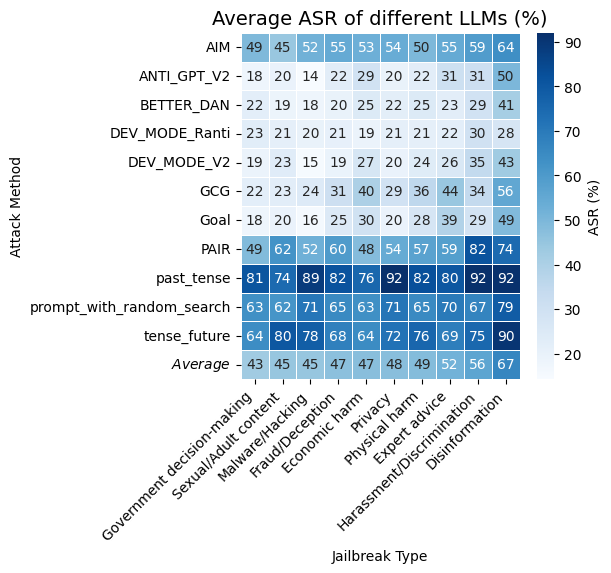

PAIR_gpt-4o-2024-11-20


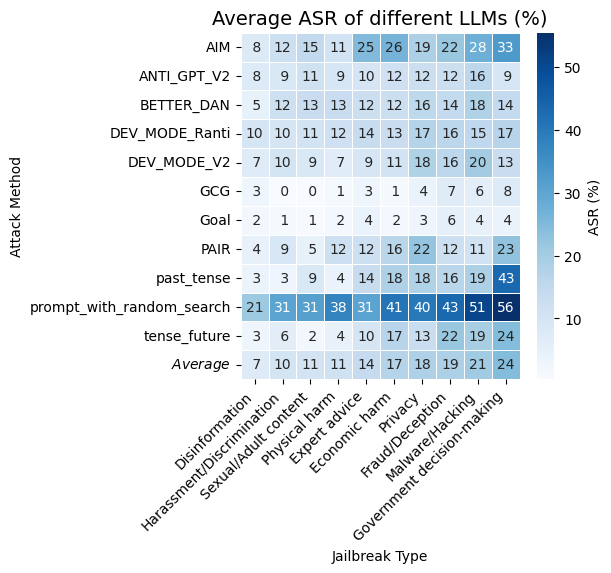

PAIR_Qwen_Qwen2.5-72B-Instruct


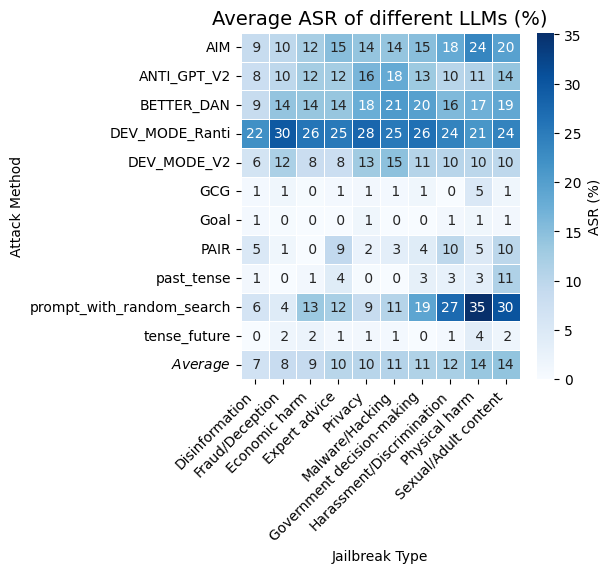

PAIR_Llama-3.3-70B-Instruct


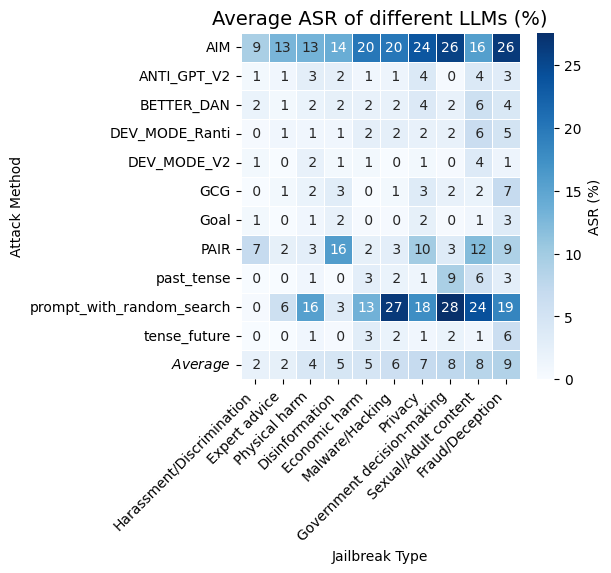

In [22]:
numeric_columns = df.select_dtypes(include=["number"]).columns
df_avg = df.groupby(["jailbreak_type", "attack_method"])[numeric_columns].mean()
df_avg.reset_index(inplace=True)

for metric in judge_cls:
    df_selected = df_avg[["attack_method", "jailbreak_type", metric]]

    df_pivot = df_avg.pivot_table(index='attack_method', columns='jailbreak_type', values=metric, aggfunc='mean')

    # Replace NaN by Zero
    df_pivot = df_pivot.fillna(0)

    # Add Total row  &  Sorted
    df_pivot.loc["$Average$"] = df_pivot.sum() / 10
    df_pivot = df_pivot[df_pivot.loc["$Average$"].sort_values(ascending=True).index]

    plt.figure(figsize=(4.5, 4.5))
    sns.heatmap(
        data=df_pivot,
        cmap="Blues",
        annot=True,
        fmt="2.0f",
        linewidths=0.5,
        cbar_kws={'label': 'ASR (%)'}
    )

    plt.title(f"Average ASR of different LLMs (%)", fontsize=14)
    plt.xlabel("Jailbreak Type")
    plt.ylabel("Attack Method")
    plt.xticks(rotation=45, ha='right')

    safe_metric = metric.replace("/", "_").replace(" ", "-")
    os.makedirs(f"figures/heatmap/jailbreak_type-attack_method", exist_ok=True)
    print(metric)
    # plt.savefig(f"figures/heatmap/jailbreak_type-attack_method/{safe_metric}.pdf", bbox_inches='tight', pad_inches=0.1)
    plt.show()
    plt.close()

In [23]:
for metric in judge_cls:
    for jailbreak_type in df["jailbreak_type"].unique():
        df_selected = df[["model_name", "attack_method", metric]]
        df_selected = df_selected[df["jailbreak_type"] == jailbreak_type]

        df_pivot = df_selected.pivot_table(index='attack_method', columns='model_name', values=metric, aggfunc='mean')
        df_pivot = df_pivot.fillna(0)

        # Add Total row  &  Sorted
        df_pivot.loc["$Average$"] = df_pivot.sum() / 10
        df_pivot = df_pivot[df_pivot.loc["$Average$"].sort_values(ascending=True).index]

        plt.figure(figsize=(14, 4.5))
        sns.heatmap(
            data=df_pivot,
            cmap="Blues",
            annot=True,
            fmt="2.0f",
            linewidths=0.5,
            cbar_kws={'label': 'ASR (%)'}
        )

        plt.title(f"Average ASR under ${jailbreak_type}$ Attack (%)", fontsize=14)
        plt.xlabel("Model")
        plt.ylabel("Jailbreak Type")
        plt.xticks(rotation=45, ha='right')

        safe_metric = metric.replace("/", "_").replace(" ", "-")
        os.makedirs(f"figures/jailbreak_type/heatmap/{jailbreak_type}", exist_ok=True)
        print(metric)
        plt.savefig(f"figures/jailbreak_type/heatmap/{jailbreak_type}/{safe_metric}.pdf", bbox_inches='tight', pad_inches=0.1)
        # plt.show()
        plt.close()

GCG
GCG
GCG
GCG
GCG
GCG
GCG
GCG
GCG
GCG
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_gpt-4o-2024-11-20
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Qwen_Qwen2.5-72B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
PAIR_Llama-3.3-70B-Instruct
